In [1]:
import pandas as pd
import numpy as np

np.float_ = np.float64

from prophet import Prophet
import requests
from datetime import datetime, timedelta
import duckdb as db

m = Prophet()
conn = db.connect("file.db")
conn.sql("""
    -- y is the amount charged for the transaction
    -- ds is the time the transaction took place

    CREATE SEQUENCE seq_id START 1;
    CREATE TABLE crypto_transfer (y INTEGER, ds DATETIME UNIQUE)
""")

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Get data

end_time = datetime.now()
print(end_time.timestamp())
start_time = (end_time - timedelta(seconds=3600.0)).timestamp()
print(start_time)

transaction_types = ["CONTRACTCALL", "CRYPTOTRANSFER"]

from typing import Union
from pprint import pprint

def get_data(start_time: float | int, limit: int, transaction_type: str, order: Union["asc", "desc"]):
    url = f"https://testnet.mirrornode.hedera.com/api/v1/transactions?limit={limit}&order={order}&timestamp=gte%3A{start_time}&transactiontype={transaction_type}"
    data = requests.get(url).json()
    transactions = data["transactions"]
    new_transactions: list[dict | None] = []
    for transaction in transactions:
        new_data = {}
        if not transaction["scheduled"] and transaction["result"] == "SUCCESS":
            _, seconds, nanoseconds = transaction["transaction_id"].split("-")
            new_data["charged_tx_fee"] = transaction["charged_tx_fee"]
            new_data["time_tx_occured"] = datetime.fromtimestamp(float(f"{seconds}.{nanoseconds}")).isoformat()

            new_transactions.append(new_data)
    return new_transactions


transactions: list[dict | None] = get_data(start_time, 100, transaction_types[1], "asc")
pprint(transactions)

1723997852.36885
1723994252.36885
[{'charged_tx_fee': 0, 'time_tx_occured': '2024-08-18T15:19:14.031572'},
 {'charged_tx_fee': 0, 'time_tx_occured': '2024-08-18T15:19:25.526270'},
 {'charged_tx_fee': 0, 'time_tx_occured': '2024-08-18T15:19:31.562108'},
 {'charged_tx_fee': 0, 'time_tx_occured': '2024-08-18T15:19:31.562108'},
 {'charged_tx_fee': 0, 'time_tx_occured': '2024-08-18T15:19:39.013899'},
 {'charged_tx_fee': 184213, 'time_tx_occured': '2024-08-18T15:19:50.728000'},
 {'charged_tx_fee': 185514, 'time_tx_occured': '2024-08-18T15:20:24.315000'},
 {'charged_tx_fee': 185514, 'time_tx_occured': '2024-08-18T15:20:24.455000'},
 {'charged_tx_fee': 185514, 'time_tx_occured': '2024-08-18T15:20:24.328000'},
 {'charged_tx_fee': 185514, 'time_tx_occured': '2024-08-18T15:20:24.437000'},
 {'charged_tx_fee': 185514, 'time_tx_occured': '2024-08-18T15:20:24.520000'},
 {'charged_tx_fee': 184213, 'time_tx_occured': '2024-08-18T15:20:26.006000'},
 {'charged_tx_fee': 184213, 'time_tx_occured': '2024-08

In [8]:
try:
    for transaction in transactions:
        conn.sql(f"""
            INSERT INTO crypto_transfer VALUES ('{transaction["charged_tx_fee"]}', '{transaction["time_tx_occured"]}')
        """)
except db.ConstraintException:
    pass

In [9]:
conn.sql("""
    SELECT * FROM crypto_transfer
""").show()

┌───────┬────────────────────────────┐
│   y   │             ds             │
│ int32 │         timestamp          │
├───────┼────────────────────────────┤
│     0 │ 2024-08-18 15:19:14.031572 │
│     0 │ 2024-08-18 15:19:25.52627  │
│     0 │ 2024-08-18 15:19:31.562108 │
└───────┴────────────────────────────┘



In [10]:
df = conn.sql("""
    SELECT ds, y FROM crypto_transfer
""").to_df()
df.tail()

,ds,y
0,2024-08-18 15:19:14.031572,0
1,2024-08-18 15:19:25.526270,0
2,2024-08-18 15:19:31.562108,0


In [11]:
m.fit(df)
future = m.make_future_dataframe(periods=1, freq="H")

/home/codespace/.python/current/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [12]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-08-18 15:19:14.031572,0.0,-1.319777e-09,1.220927e-09,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2024-08-18 15:19:25.526270,0.0,-1.297779e-09,1.240350e-09,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2024-08-18 15:19:31.562108,0.0,-1.302658e-09,1.314165e-09,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2024-08-18 16:19:31.562108,0.0,-2.436695e-09,2.429741e-09,-2.154073e-09,2.190752e-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/home/codespace/.python/current/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/codespace/.python/current/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


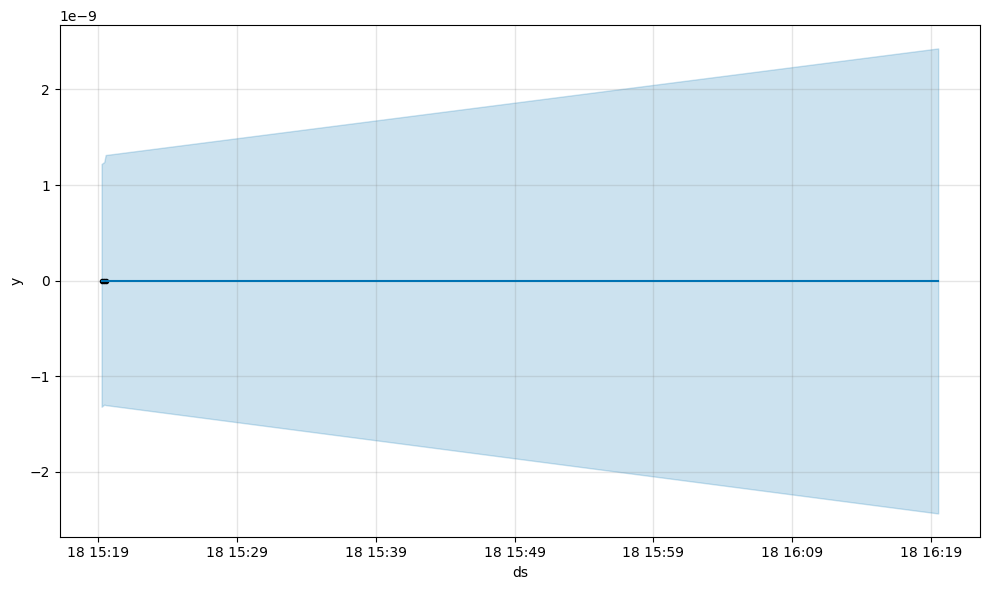

In [13]:
fig1 = m.plot(forecast)

/home/codespace/.python/current/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


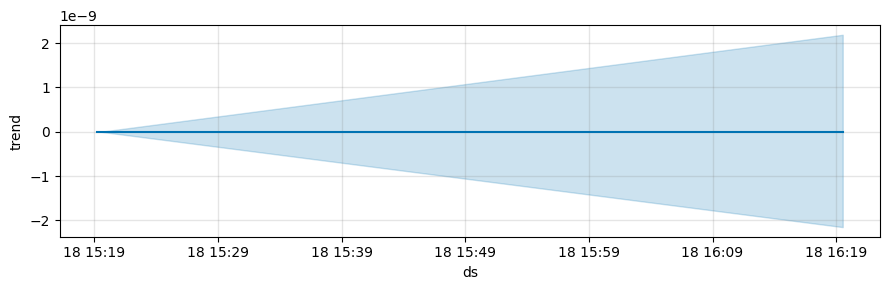

In [14]:
fig2 = m.plot_components(forecast)

In [15]:
forecast[["ds", "yhat"]].tail()

,ds,yhat
0,2024-08-18 15:19:14.031572,0.0
1,2024-08-18 15:19:25.526270,0.0
2,2024-08-18 15:19:31.562108,0.0
3,2024-08-18 16:19:31.562108,0.0


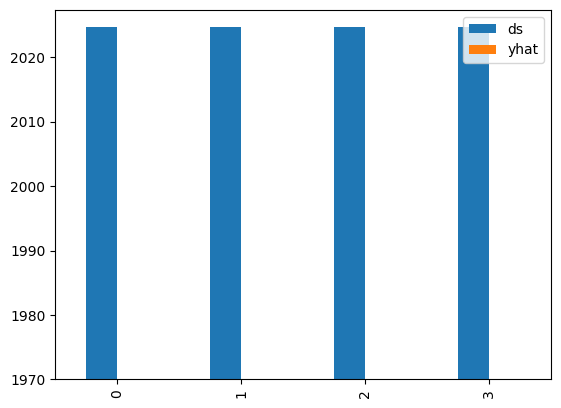

In [19]:
fig3 = forecast[["ds", "yhat"]].plot.bar()

In [16]:
forecast_dict = forecast[["ds", "yhat"]].to_dict()
pprint(forecast_dict)

{'ds': {0: Timestamp('2024-08-18 15:19:14.031572'),
        1: Timestamp('2024-08-18 15:19:25.526270'),
        2: Timestamp('2024-08-18 15:19:31.562108'),
        3: Timestamp('2024-08-18 16:19:31.562108')},
 'yhat': {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0}}


In [17]:
new_data = {"x": [], "y": []}

ds = forecast_dict["ds"]
y = forecast_dict["yhat"]
for value in ds.values():
    new_data["x"].append(str(value))
for value in y.values():
    new_data["y"].append(value)

id = "".join(["predict-", str(datetime.fromisoformat(new_data["x"][0]).timestamp()), "-", str(datetime.fromisoformat(new_data["x"][-1]).timestamp())])
new_data["id"] = id
new_data["created_at"] = datetime.now()

pprint(new_data)

{'created_at': datetime.datetime(2024, 8, 18, 16, 18, 49, 978233),
 'id': 'predict-1723994354.031572-1723997971.562108',
 'x': ['2024-08-18 15:19:14.031572',
       '2024-08-18 15:19:25.526270',
       '2024-08-18 15:19:31.562108',
       '2024-08-18 16:19:31.562108'],
 'y': [0.0, 0.0, 0.0, 0.0]}
